####################################################
##
##  Cristhian Augusto Plazas Ortega
##  Data Scientist
##  MSc student on Engineerng Information
##  cristhianplaza.o@gmail.com
##
#####################################################



In [392]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

## Redaction Problem

*   Encounter ID: ID of the encounter
*   Patient number: ID of the patient
*   Race Values: Caucasian, Asian, African American, Hispanic, and other
*   Gender Values: male, female, and unknown/invalid
*   Age: 10 years grouped range age
*   Weight: Weight of patient
*   Admission type: Type of admission corresponding to 9 distinct values, ie., emergency, urgent, elective, newborn, and not available
*   Discharge disposition: Discharge disposition corresponding to 29 distinct values.
*   Admission source: Admission source corresponding to 21 distinct values, ie., physician referral, emergency room, and transfer from a hospital
*   Time in hospital: Number of days between admission and discharge
*   Payer code : Type of payer code
*   Medical specialty: Medical specialty of the admitting corresponding to 84 distinct values
*   Number of lab procedures: Number of lab tests performed during the encounter
*   Number of procedures: Number of procedures performed during the encounter different than lab procedures
*   Number of medications: Number of distinct generic names administered during the encounter
*   Number of outpatient visits: Number of outpatient visits in the encounter
*   Number of emergency visits: Number of emergency visits of the patient in the year
*   Number of inpatient visits: Number of inpatient visits of the patient in the year
*   Diagnosis 1: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
*   Diagnosis 2: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
*   Diagnosis 3: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
*   Number of diagnoses : Number of diagnoses
*   Glucose serum test : Indicates the range of the result, ie., “>200,” “>300,” “normal,” and “none”
*   A1c test result : Indicates the range of the result. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none”
*   Change of medications: Indicates if there was a change in diabetic medications including dosage or generic name.
*   Diabetes medications : Indicates if there was any diabetic medication prescribed. Values: “yes” and “no” 
*   Readmitted: Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

In [339]:
df_diabetic = pd.read_csv("diabetic_data.csv")
df_id_diabetic = pd.read_csv("IDs_mapping.csv")
df_diabetic.replace('?', np.nan , inplace=True)

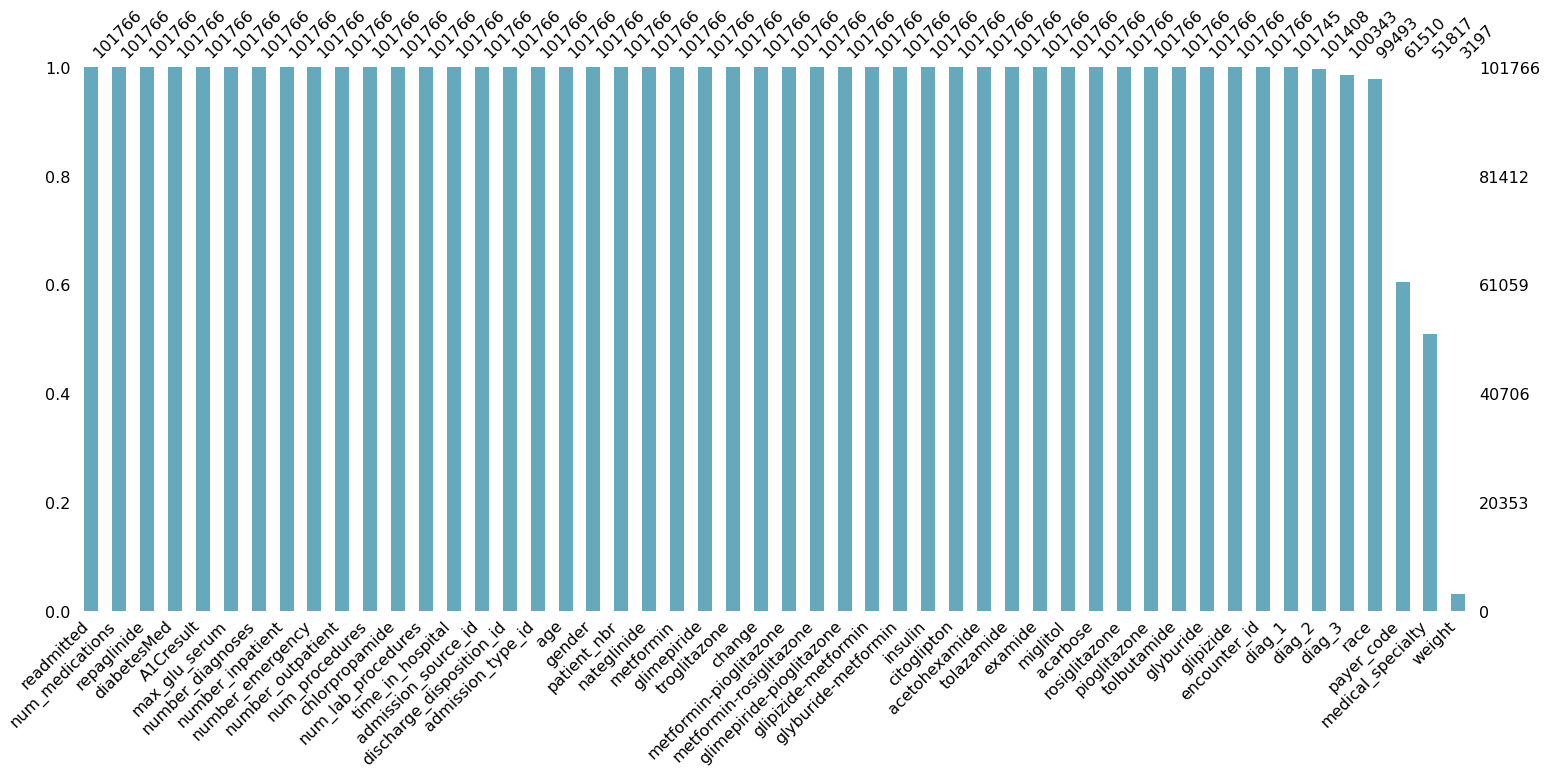

In [319]:
msno.bar(df_diabetic,sort='descending',color='#66a9bc')
plt.show()

## Removing Variables that doesn't gives information

In [340]:
columns_diabectic = df_diabetic.columns
Field = [col for col in columns_diabectic]
Missing = [round(df_diabetic[col].isnull().sum()/df_diabetic[col].shape[0],4) for col in columns_diabectic]
Constant = [len(df_diabetic[col].unique()) for col in columns_diabectic]
df_description = pd.DataFrame({
    "Field":Field,
    "% Missing":Missing,
    "Qty Unique":Constant
})

df_description["Suggestion"] = df_description.apply(lambda x: "Remove" if x["% Missing"] > 0.3 or x["Qty Unique"] == 1 else "Not Remove", axis=1)
df_diabetic.drop(df_description.loc[df_description["Suggestion"].isin(["Remove"])]["Field"].tolist()+["encounter_id","diag_2", "diag_3","patient_nbr"], axis=1, inplace=True)

In [421]:
df_description.loc[df_description["Suggestion"].isin(["Remove"])]

,Field,% Missing,Qty Unique,Suggestion
5,weight,0.9686,10,Remove
10,payer_code,0.3956,18,Remove
11,medical_specialty,0.4908,73,Remove
39,examide,0.0000,1,Remove
40,citoglipton,0.0000,1,Remove


## Counting number of changes due to its relation with the readmission

In [341]:
columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in columns:
    df_diabetic[f"{col}_tmp"] = df_diabetic[col].apply(lambda x: 0 if x == "No" or x == "Steady" else 1)

df_diabetic["Qty Changes"] = df_diabetic[[f"{col}_tmp" for col in columns]].apply(lambda x:x.sum(), axis=1)

for col in columns:
    df_diabetic.drop([f"{col}_tmp"], axis=1, inplace=True)

## Grouping similar values by Column

### admission_type_id
    (1) Emergency --> 1
    (1) Emergency --> 2
    (3) Elective --> 3
    (4) New Born --> 4
    (5) Undefined --> 5
    (5) Undefined --> 6
    (5) Undefined --> 8
    (7) Trauma Center --> 7

### discharge_disposition_id
    (1) Home --> 1
    (1) Home --> 6
    (1) Home --> 8
    (1) Home --> 13
    (1) Home --> 19
    (3) HighAttention --> 3
    (3) HighAttention --> 4    
    (12) OutpatientServices --> 12
    (12) OutpatientServices --> 16
    (12) OutpatientServices --> 17
    (18) Undefined --> 18
    (18) Undefined --> 25
    (18) Undefined --> 26
    (2) OtherHospital --> 2
    (2) OtherHospital --> 23
    (2) OtherHospital --> 24
    (2) OtherHospital --> 30
    (2) OtherHospital --> 27
    (2) OtherHospital --> 29
    (2) OtherHospital --> 14
    (2) OtherHospital --> 5
    (2) OtherHospital --> 22
    (11) Expired --> 11
    (11) Expired --> 19
    (11) Expired --> 20
    (11) Expired --> 21

### admission_source_id
    (9) Undefined --> 15
    (9) Undefined --> 17
    (9) Undefined --> 20
    (9) Undefined --> 21
    (4) Transfers --> 5
    (4) Transfers --> 6
    (4) Transfers --> 10
    (4) Transfers --> 18
    (4) Transfers --> 22
    (4) Transfers --> 25
    (4) Transfers --> 26
    (1) Referrals --> 1
    (1) Referrals --> 2
    (1) Referrals --> 3

### diag_1
    (1) Circulatory
    (2) Diabetes
    (3) Respiratory
    (4) Digestive
    (5) Injury and Poisoning
    (6) Musculoskeletal
    (7) Genitourinary
    (8) Neoplasms
    (9) Other

### race
    (1) Caucasian
    (2) AfricanAmerican
    (3) Other
    (4) Hispanic
    (5) Undefined 


In [342]:
df_diabetic["admission_type_id"] = df_diabetic["admission_type_id"].apply(lambda x: 5 if x == 6 or x == 8 
                                                                                            else ( 1 if x == 2 else x ))
df_diabetic["discharge_disposition_id"] = df_diabetic["discharge_disposition_id"].apply(lambda x: 1 if x == 6 or x == 8 or x == 13 or x == 19 
                                                                                                        else ( 3 if x == 4 
                                                                                                        else ( 12 if x == 16 or x == 17 
                                                                                                        else ( 18 if x == 25 or x == 26 
                                                                                                        else ( 2 if x == 23 or x == 24 or x == 30 or x == 27 or x == 29 or x == 14 or x == 5 or x == 22 
                                                                                                        else ( 11 if x == 19 or x == 20 or x == 21 else x ))))))
df_diabetic["admission_source_id"] = df_diabetic["admission_source_id"].apply(lambda x: 9 if x == 15 or x == 17 or x == 20 or x == 21 
                                                                                                else ( 4 if x == 5 or x == 6 or x == 10 or x == 18 or x == 22 or x == 25 or x == 26 
                                                                                                else ( 1 if x == 2 or x == 3 else x )))
df_diabetic["diag_1"] = df_diabetic["diag_1"].apply(lambda x: 0 if str(x).__contains__("V") or str(x).__contains__("E") else float(x))                                                                                                
df_diabetic.loc[(df_diabetic["diag_1"] >= 390) & (df_diabetic["diag_1"] <= 459) & (df_diabetic["diag_1"].isin([785])), "diag_1"] = 1
df_diabetic.loc[(df_diabetic["diag_1"] >= 250.00) & (df_diabetic["diag_1"] <= 250.99), "diag_1"] = 2
df_diabetic.loc[(df_diabetic["diag_1"] >= 460) & (df_diabetic["diag_1"] <= 519) & (df_diabetic["diag_1"].isin([786])), "diag_1"] = 3
df_diabetic.loc[(df_diabetic["diag_1"] >= 520) & (df_diabetic["diag_1"] <= 579) & (df_diabetic["diag_1"].isin([787])), "diag_1"] = 4
df_diabetic.loc[(df_diabetic["diag_1"] >= 800) & (df_diabetic["diag_1"] <= 999), "diag_1"] = 5
df_diabetic.loc[(df_diabetic["diag_1"] >= 710) & (df_diabetic["diag_1"] <= 739), "diag_1"] = 6
df_diabetic.loc[(df_diabetic["diag_1"] >= 580) & (df_diabetic["diag_1"] <= 629) & (df_diabetic["diag_1"].isin([788])), "diag_1"] = 7
df_diabetic.loc[(df_diabetic["diag_1"] >= 140) & (df_diabetic["diag_1"] <= 239), "diag_1"] = 8
df_diabetic.loc[~df_diabetic["diag_1"].isin([1,2,3,4,5,6,7,8]), "diag_1"] = 9
df_diabetic["race"] = df_diabetic["race"].apply(lambda x: 1 if x == "Caucasian" 
                                                                else ( 2 if x == "AfricanAmerican" 
                                                                else ( 3 if x == "Other" 
                                                                else ( 4 if x == "Hispanic" else 5 ))))
df_diabetic["gender"] = df_diabetic["gender"].apply(lambda x: 1 if x == "Female" 
                                                                    else ( 2 if x == "Male" else 3 ))
df_diabetic["age"] = df_diabetic["age"].apply(lambda x: 1 if x == "[0-10)" or x == "[10-20)" or x == "[20-30)"
                                                                else ( 2 if x == "[30-40)" or x == "[40-50)" or x == "[50-60)" else 3 ))
df_diabetic["max_glu_serum"] = df_diabetic["max_glu_serum"].apply(lambda x: 1 if x == ">200" or x == ">300"
                                                                                else ( 2 if x == "Norm" else 3 ))
df_diabetic["A1Cresult"] = df_diabetic["A1Cresult"].apply(lambda x: 1 if x == ">7" or x == ">8"
                                                                                else ( 2 if x == "Norm" else 3 ))
df_diabetic["change"] = df_diabetic["change"].apply(lambda x: 1 if x == "Ch" else 0 )
df_diabetic["diabetesMed"] = df_diabetic["diabetesMed"].apply(lambda x: 1 if x == "Yes" else 0 )
df_diabetic["readmitted"] = df_diabetic["readmitted"].apply(lambda x: 1 if x == "<30" else 0 )

for col in columns:
    df_diabetic[col] = df_diabetic[col].apply(lambda x: 1 if x == "Steady" or x == "Up" or x == "Down" else 0 )                                                               

## Numerical Fields

In [343]:
df_numerical = df_diabetic[["time_in_hospital","num_lab_procedures","num_procedures","num_medications","number_outpatient","number_emergency","number_inpatient","number_diagnoses","Qty Changes"]]
df_numerical_scaled = np.log1p(df_numerical)
df_kurtosis = pd.concat([df_numerical.kurtosis().to_frame().rename(columns={0:"Kurtosis"}), df_numerical_scaled.kurtosis().to_frame().rename(columns={0:"Kurtosis_Transformed"})],axis=1)
df_numerical.drop(["num_medications","number_outpatient","number_emergency","number_inpatient"], axis=1, inplace=True)
df_numerical = pd.concat([df_numerical,df_numerical_scaled[["num_medications","number_outpatient","number_emergency","number_inpatient"]]], axis=1)

C:\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [423]:
df_numerical_scaled

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,Qty Changes
0,0.693147,3.737670,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000
1,1.386294,4.094345,0.000000,2.944439,0.000000,0.0,0.000000,2.302585,0.693147
2,1.098612,2.484907,1.791759,2.639057,1.098612,0.0,0.693147,1.945910,0.000000
3,1.098612,3.806662,0.693147,2.833213,0.000000,0.0,0.000000,2.079442,0.693147
4,0.693147,3.951244,0.000000,2.197225,0.000000,0.0,0.000000,1.791759,0.000000
...,...,...,...,...,...,...,...,...,...
101761,1.386294,3.951244,0.000000,2.833213,0.000000,0.0,0.000000,2.302585,0.693147
101762,1.791759,3.526361,1.386294,2.944439,0.000000,0.0,0.693147,2.302585,0.000000
101763,0.693147,3.988984,0.000000,2.302585,0.693147,0.0,0.000000,2.639057,0.693147
101764,2.397895,3.828641,1.098612,3.091042,0.000000,0.0,0.693147,2.302585,0.693147


In [422]:
df_kurtosis

,Kurtosis,Kurtosis_Transformed
time_in_hospital,0.850251,-0.757701
num_lab_procedures,-0.245074,5.033659
num_procedures,0.857110,-1.077002
num_medications,3.468155,0.909945
number_outpatient,147.907736,7.852021
number_emergency,1191.686726,16.202783
number_inpatient,20.719397,1.375212
number_diagnoses,-0.079056,2.312145
Qty Changes,1.420487,-0.410665


## Replacing Numerical Transforms Data

In [344]:
df_diabetic.drop(df_numerical.columns.tolist(), axis=1, inplace=True)
df_diabetic = pd.concat([df_diabetic, df_numerical], axis=1)

In [352]:
corr_map = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
corr_table = df_diabetic.corr(method='pearson')
corr_table.style.background_gradient(cmap=corr_map, axis = 0)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,time_in_hospital,num_lab_procedures,num_procedures,number_diagnoses,Qty Changes,num_medications,number_outpatient,number_emergency,number_inpatient
race,1.000000,-0.018374,-0.091100,-0.045846,-0.008356,-0.002681,-0.023227,0.028496,-0.036011,0.000223,-0.014565,0.004127,-0.006243,-0.005680,-0.001440,-0.005876,-0.011817,-0.003085,-0.014154,-0.008165,-0.007116,-0.005310,-0.002494,-0.004886,0.039220,0.009075,-0.005192,-0.001440,0.018692,-0.001440,0.008087,0.013053,-0.013488,-0.008731,0.013155,-0.021033,-0.103113,0.007007,-0.059181,-0.058710,-0.002240,-0.030647
gender,-0.018374,1.000000,-0.017445,0.013712,-0.006358,-0.009590,-0.011987,0.002512,-0.022685,0.001720,-0.005442,-0.005020,0.004225,0.001116,-0.002907,0.026812,0.032703,0.000477,0.004514,0.012740,0.012042,0.006556,0.005853,0.007012,0.000907,0.003684,0.006954,-0.002907,0.004779,-0.002907,0.014905,0.015901,-0.002939,-0.029928,-0.003103,0.059980,-0.003407,0.006775,-0.034650,-0.013328,-0.028703,-0.014418
age,-0.091100,-0.017445,1.000000,0.007368,0.041444,0.010229,0.179760,-0.018757,0.121257,-0.030982,0.040286,0.015516,0.012974,0.034763,0.002091,0.053146,0.076321,0.007545,0.022178,0.010715,0.007867,0.011925,-0.003254,0.003523,-0.078470,0.003577,0.000933,0.002091,0.002957,0.002091,-0.021700,-0.010410,0.018429,0.096171,0.011713,0.008326,0.221113,-0.057716,0.099234,0.032143,-0.092198,-0.010919
admission_type_id,-0.045846,0.013712,0.007368,1.000000,0.068011,-0.185660,-0.009077,-0.402212,0.056944,0.020733,-0.016800,-0.009889,0.008843,-0.011973,-0.001838,0.009343,0.004879,0.005907,0.014494,0.017030,0.004761,-0.003695,0.002251,0.008119,-0.031417,-0.002344,-0.002711,-0.001838,0.000729,0.002869,0.010327,-0.001692,-0.012011,-0.022651,-0.158974,0.115232,-0.104957,0.016244,0.092883,0.059798,-0.024918,-0.042098
discharge_disposition_id,-0.008356,-0.006358,0.041444,0.068011,1.000000,0.014838,-0.000292,-0.041268,0.006048,-0.021018,-0.015495,-0.017786,0.027584,-0.032997,-0.000308,-0.031239,0.057113,0.000376,-0.028645,-0.014581,0.004131,0.000591,0.007403,0.016594,-0.086719,-0.016287,-0.002234,-0.001117,-0.001580,0.000500,-0.058795,-0.063655,0.012744,0.082388,0.021774,0.013879,-0.019898,-0.030832,0.011784,-0.048868,-0.039493,0.013995
admission_source_id,-0.002681,-0.009590,0.010229,-0.185660,0.014838,1.000000,0.039913,-0.235394,-0.046347,-0.040562,0.010876,-0.011958,-0.005113,-0.025006,0.002034,0.004498,-0.005595,0.002484,-0.016305,-0.023932,-0.000381,0.002286,0.003524,0.001709,0.026376,-0.017877,0.001894,0.002034,-0.001747,-0.004506,0.006230,-0.000128,0.012906,0.001138,0.159462,-0.190837,0.116339,0.036820,-0.075815,0.011313,0.100085,0.065063
diag_1,-0.023227,-0.011987,0.179760,-0.009077,-0.000292,0.039913,1.000000,-0.001841,0.085688,-0.005194,0.008060,0.001701,0.005695,0.013928,0.001542,0.029433,0.030346,-0.002893,0.002787,-0.000185,0.004245,0.000795,0.000157,0.002426,-0.100579,-0.004211,0.002340,-0.008615,0.002180,-0.002811,-0.068419,-0.053590,-0.016490,0.001204,0.018182,0.033581,0.106977,-0.096873,0.025980,-0.005064,-0.040125,-0.026309
max_glu_serum,0.028496,0.002512,-0.018757,-0.402212,-0.041268,-0.235394,-0.001841,1.000000,-0.057764,0.027316,0.016347,0.017268,-0.003943,0.031542,0.000699,-0.004494,-0.002686,-0.009475,0.016188,0.004130,-0.003260,0.004310,0.001211,0.000144,-0.014585,0.017311,0.002521,0.000699,0.000989,0.000699,-0.008095,0.003430,-0.010814,-0.022651,0.144569,0.073352,0.046245,-0.031142,-0.003285,-0.076036,-0.054895,-0.026225
A1Cresult,-0.036011,-0.022685,0.121257,0.056944,0.006048,-0.046347,0.085688,-0.057764,1.000000,-0.046221,-0.025328,0.000116,0.003

## Data Visualization

## PCA Decomposition to Extract Patterns

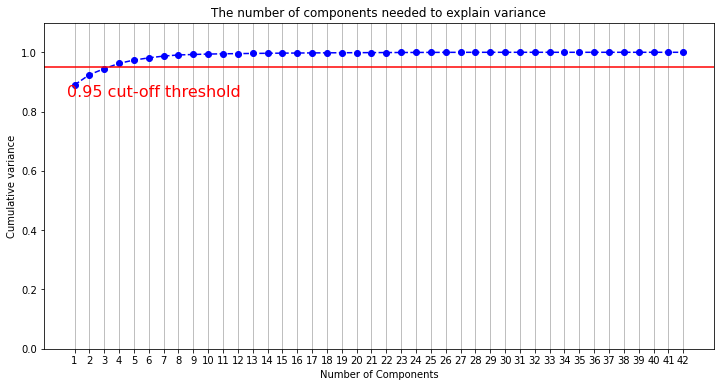

In [394]:
pca = PCA(random_state=42).fit(df_diabetic)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 43, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 43, step=1)) 
plt.ylabel('Cumulative variance')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, "0.95 cut-off threshold", color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [412]:
X = df_diabetic.drop(["readmitted"], axis=1)
y = df_diabetic["readmitted"]
pca = PCA(n_components=3, random_state=42).fit(X)
df_pca = pd.DataFrame(pca.fit_transform(X, y), columns=["FirstComponent","SecondComponent","ThirdComponent"])

In [424]:
pca.explained_variance_ratio_

array([0.88992513, 0.03470173, 0.0202207 ])

In [416]:
from scipy import stats
df_factor_analysis = pd.DataFrame()
for col_pca in df_pca:
    pca_component = []
    diabetic_factor = []
    for col_diabetic in X.columns:    
        pca_component.append(stats.spearmanr(df_pca[col_pca], X[col_diabetic])[0])
        diabetic_factor.append(col_diabetic)
    df_temp = pd.DataFrame({
        f"{col_pca}":pca_component,
        f"diabetic_col":diabetic_factor    
    }).set_index("diabetic_col")
    df_factor_analysis = pd.concat([df_factor_analysis, df_temp], axis=1)


In [417]:
df_factor_analysis

,FirstComponent,SecondComponent,ThirdComponent
diabetic_col,,,
race,0.013649,-0.044639,-0.019347
gender,-0.008537,-0.049536,-0.007559
age,0.015775,0.174045,0.058590
admission_type_id,-0.199491,0.128957,0.256100
discharge_disposition_id,0.062275,0.779833,0.010785
admission_source_id,0.139451,-0.011511,-0.724916
diag_1,0.056239,-0.060167,-0.098001
max_glu_serum,0.172277,-0.134292,0.158057
A1Cresult,-0.259790,0.084762,0.024665
